In [4]:
import pandas as pd
import numpy as np
import joblib as jb
import math

pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [5]:
def root_mean_squared_error(y_test, preds):
    return math.sqrt(mean_squared_error(y_true=y_test, y_pred=preds))    

### Generate labels

In [6]:
month_to_predict_1 = 33
month_to_predict_2 = 32
month_to_predict_3 = 31
month_to_predict_4 = 30

In [7]:
items = pd.read_csv("data/items.csv")
items_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
shops = pd.read_csv("data/shops.csv")

In [8]:
df = pd.merge(items, items_categories, on="item_category_id", how="inner")
df = pd.merge(df, sales_train, on="item_id", how="inner")
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [9]:
def label_df(df, month_to_label):
    to_label = df[df["date_block_num"] == month_to_label]
    
    print("Before deleting negative item_cnt_day:", len(to_label))
    to_label = to_label[to_label["item_cnt_day"] > 0]
    print("After deleting negative item_cnt_day", len(to_label))
    
    labeled = to_label.groupby(["shop_id", "item_id"]).agg({"item_cnt_day":"sum", "item_category_id":"max"}).reset_index().rename(columns={"item_cnt_day":"label"})
    
    print("Before taking 99th percentil of label:", len(labeled))
    labeled = labeled[labeled.label <= np.percentile(a=labeled["label"], q=99)]
    print("After taking 99th percentil of label:", len(labeled))    
    return labeled

In [10]:
labeled_1 = label_df(df, month_to_predict_1)

Before deleting negative item_cnt_day: 53514
After deleting negative item_cnt_day 53386
Before taking 99th percentil of label: 31521
After taking 99th percentil of label: 31218


In [11]:
labeled_2 = label_df(df, month_to_predict_2)

Before deleting negative item_cnt_day: 50588
After deleting negative item_cnt_day 50443
Before taking 99th percentil of label: 29652
After taking 99th percentil of label: 29382


In [12]:
labeled_3 = label_df(df, month_to_predict_3)

Before deleting negative item_cnt_day: 57029
After deleting negative item_cnt_day 56913
Before taking 99th percentil of label: 33472
After taking 99th percentil of label: 33180


In [13]:
labeled_4 = label_df(df, month_to_predict_4)

Before deleting negative item_cnt_day: 55549
After deleting negative item_cnt_day 55420
Before taking 99th percentil of label: 33515
After taking 99th percentil of label: 33181


In [14]:
print(len(labeled_1))
labeled_1.head()

31218


,shop_id,item_id,label,item_category_id
0,2,31,1.0,37
1,2,486,3.0,73
2,2,787,1.0,49
3,2,794,1.0,73
4,2,968,1.0,40


In [15]:
labeled_1.head()

,shop_id,item_id,label,item_category_id
0,2,31,1.0,37
1,2,486,3.0,73
2,2,787,1.0,49
3,2,794,1.0,73
4,2,968,1.0,40


#### Generate dataframe with features

In [12]:
#Dictionary whose keys are features files and associated values are joining columns
features_folders = ["generated/features_train_1/", "generated/features_train_2/", "generated/features_train_3/", "generated/features_train_4/"]

#Debe coincider el mes para que se calculo el label con el mes para el cual se generaron los features.
dfs_init = [labeled_1, labeled_2, labeled_3, labeled_4]

features_dict = {
    "features_shop_and_categories.csv":["shop_id", "item_category_id"],
    "features_categories.csv":"item_category_id",
    "features_shops.csv":"shop_id",
    "features_items_and_shop.csv": ["item_id", "shop_id"],
    "features_items.csv":"item_id"    
}

In [13]:
dfs = []
for x in range(len(features_folders)):
    df = dfs_init[x]
    features_folder = features_folders[x]    
    for features_file in features_dict:
        df_features = pd.read_csv(features_folder + features_file)
        joining_cols = features_dict[features_file]
        df = pd.merge(df, df_features, on=joining_cols, how="left")
    dfs.append(df)    
print(len(dfs))

4


In [1]:
'''df = dfs[0]
for x in range(1, len(dfs)):
    df = df.append(dfs[x])
    
print("Len of train datarame:", len(df))
df.head()'''

'df = dfs[0]\nfor x in range(1, len(dfs)):\n    df = df.append(dfs[x])\n    \nprint("Len of train datarame:", len(df))\ndf.head()'

#### Analyze and fill na values of dataframe with features

In [15]:
df.isna().sum()

shop_id                                         0
item_id                                         0
label                                           0
item_category_id                                0
hist_sales_sum_cat_by_shop                    420
hist_sales_mean_cat_by_shop                   420
hist_sales_std_cat_by_shop                    907
hist_sales_min_cat_by_shop                    420
hist_sales_max_cat_by_shop                    420
sold_cat_last_month_by_shop                  1916
total_shops_of_category                         2
total_items_of_category                         2
mean_sales_of_category_by_month                 2
tot_cat_by_shops                              258
items_sold_last_month                         258
items_sold_by_shop_last_2_months              966
items_sold_by_shop_last_3_months              966
items_sold_by_shop_last_4_months              966
items_sold_by_shop_last_5_months             1275
items_sold_by_shop_last_6_months             1272


In [16]:
df["hist_sales_sum_cat_by_shop"] = df["hist_sales_sum_cat_by_shop"].fillna(0)
df["hist_sales_mean_cat_by_shop"] = df["hist_sales_mean_cat_by_shop"].fillna(0)
df["hist_sales_max_cat_by_shop"] = df["hist_sales_max_cat_by_shop"].fillna(0)
df["hist_sales_min_cat_by_shop"] = df["hist_sales_min_cat_by_shop"].fillna(0)
df["sold_cat_last_month_by_shop"] = df["sold_cat_last_month_by_shop"].fillna(0)
df["tot_cat_by_shops"] = df["tot_cat_by_shops"].fillna(df["tot_cat_by_shops"].mean())
df["items_sold_last_month"] = df["items_sold_last_month"].fillna(0)
df["hist_sales_mean_item_by_shop"] = df["hist_sales_mean_item_by_shop"].fillna(0)
df["hist_sales_sum_item_by_shop"] = df["hist_sales_sum_item_by_shop"].fillna(0)
df["hist_sales_max_item_by_shop"] = df["hist_sales_max_item_by_shop"].fillna(0)
df["hist_sales_min_item_by_shop"] = df["hist_sales_min_item_by_shop"].fillna(0)
df["purchases_item_in_shop_last_month"] = df["purchases_item_in_shop_last_month"].fillna(0)
for x in range(5):
    df["purchases_item_in_shop_month_" + str(x+2)].fillna(0, inplace=True)
df["total_months_with_sells_by_item_and_shop"] = df["total_months_with_sells_by_item_and_shop"].fillna(0)    
for x in range(2, 7):
    df["items_sold_by_shop_last_" + str(x) + "_months"] = df["items_sold_by_shop_last_" + str(x) + "_months"].fillna(0) 
for x in range(1, 6):
    df["total_sales_with_" + str(x) +"_units"] = df["total_sales_with_" + str(x) +"_units"].fillna(0)
df["months_item_has_sales"] = df["months_item_has_sales"].fillna(0)
df.sample(10)

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units
15821,35,2788,2.0,20,2405.0,109.318182,54.869878,10.0,284.0,124.0,52.0,129.0,1.279452,62.0,1628.0,1296.0,1174.0,1332.0,1361.0,1610.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
11113,25,5165,1.0,67,5430.0,164.545455,92.988941,57.0,537.0,65.0,58.0,393.0,1.056064,65.0,4562.0,4259.0,4250.0,4547.0,4506.0,4862.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
24528,47,4049,1.0,23,4077.0,135.900000,53.906912,63.0,318.0,99.0,57.0,474.0,1.124067,60.0,1562.0,1674.0,1553.0,1934.0,1990.0,2254.0,1.000000,3.0,0.000000,1.0,1.0,1.000000,3.0,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,22.0,3.0,2499.0,1885.203786,1249.00,319.596416,1250.00,48.0,24.000000,24.000000,9.0,197.0,8.0,1.0,0.0,0.0
3759,12,482,7.0,73,1692.0,52.875000,26.630991,19.0,129.0,26.0,55.0,36.0,1.136226,63.0,1351.0,1107.0,1279.0,889.0,1310.0,1252.0,7.454545,82.0,2.544156,11.0,3.0,12.968750,415.0,7.843158,38.0,2.0,6.0,3.0,10.0,11.0,10.0,9.0,31.0,0.0,32.0,3300.0,3232.018079,1212.85,279.674299,2087.15,54.0,82.500000,61.090909,32.0,1942.0,236.0,60.0,9.0,2.0
166,2,4390,1.0,24,202.0,18.363636,10.394929,1.0,37.0,15.0,51.0,92.0,1.112879,59.0,789.0,790.0,709.0,704.0,711.0,863.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2999.0,2998.945833,2998.35,0.187639,0.65,10.0,12.000000,12.000000,1.0,12.0,0.0,0.0,0.0,0.0
29430,57,13285,1.0,47,23.0,4.600000,3.781534,1.0,10.0,10.0,42.0,110.0,1.068006,61.0,2228.0,2736.0,2323.0,2414.0,2289.0,2711.0,1.000000,1.0,NaN,1.0,1.0,1.000000,1.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0,30.0,1.0,469.0,463.054038,322.00,24.571454,147.00,29.0,36.666667,36.666667,3.0,98.0,6.0,0.0,0.0,0.0
23553,46,11631,1.0,37,4026.0,129.870968,52.939426,68.0,288.0,91.0,57.0,1759.0,1.058590,60.0,1625.0,1441.0,1339.0,1233.0,1535.0,1578.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,499.0,471.478261,283.00,72.704801,216.00,16.0,2.090909,1.000000,11.0,23.0,0.0,0.0,0.0,0.0
5664,15,4351,7.0,30,12683.0,409.129032,182.588562,163.0,758.0,166.0,57.0,745.0,1.183541,59.0,1219.0,1264.0,1154.0,1157.0,1288.0,1455.0,4.181818,46.0,3.572623,13.0,1.0,6.047619,127.0,5.731284,23.0,1.0,3.0,3.0,9.0,3.0,2.0,1.0,30.0,10.0,21.0,399.0,395.310509,220.03,21.961735,178.97,52.0,176.666667,112.454545,21.0,2642.0,361.0,82.0,20.0,4.0
619,3,6085,1.0,20,1113.0,50.590909,27.482738,13.0,117.0,56.0,52.0,129.0,1.279452,58.0,662.0,542.0,670.0,708.0,687.0,741.0,1.833333,11.0,0.983192,3.0,1.0,1.625000,13.0,0.916125,3.0,1.0,

In [17]:
df.isna().sum()

shop_id                                         0
item_id                                         0
label                                           0
item_category_id                                0
hist_sales_sum_cat_by_shop                      0
hist_sales_mean_cat_by_shop                     0
hist_sales_std_cat_by_shop                    907
hist_sales_min_cat_by_shop                      0
hist_sales_max_cat_by_shop                      0
sold_cat_last_month_by_shop                     0
total_shops_of_category                         2
total_items_of_category                         2
mean_sales_of_category_by_month                 2
tot_cat_by_shops                                0
items_sold_last_month                           0
items_sold_by_shop_last_2_months                0
items_sold_by_shop_last_3_months                0
items_sold_by_shop_last_4_months                0
items_sold_by_shop_last_5_months                0
items_sold_by_shop_last_6_months                0


### Some section to generate mean encodings of categorical variables

In [18]:
def mean_encode_smoothed(df, categorical_variable, target_column, smooth):
    prior = df[target_column].mean()
    n = df.groupby(categorical_variable).size()
    mu = df.groupby(categorical_variable)[target_column].mean()
    mu_smoothed = (n * mu + smooth * prior) / (n + smooth)
    
    df.loc[:, categorical_variable + '_m_e'] = df[categorical_variable].map(mu_smoothed)
    return df, mu_smoothed

In [19]:
df, category_encoding = mean_encode_smoothed(df, 'item_category_id', 'label', 30)
df, item_encoding = mean_encode_smoothed(df, 'item_id', 'label', 30)
df, shop_encoding = mean_encode_smoothed(df, 'shop_id', 'label', 30)

In [20]:
jb.dump(category_encoding, 'encodings/category_id_me.pkl')
jb.dump(item_encoding, 'encodings/item_id_me.pkl')
jb.dump(shop_encoding, 'encodings/shop_id_me.pkl')

['encodings/shop_id_me.pkl']

In [ ]:
### 

## Define target, prediction columns and train model

In [21]:
features = df

In [22]:
target_col = "label"
predictors = [x for x in features.columns if x != target_col]
jb.dump(predictors, "model_parameters/predictors_xgboost.pkl")
predictors

['shop_id',
 'item_id',
 'item_category_id',
 'hist_sales_sum_cat_by_shop',
 'hist_sales_mean_cat_by_shop',
 'hist_sales_std_cat_by_shop',
 'hist_sales_min_cat_by_shop',
 'hist_sales_max_cat_by_shop',
 'sold_cat_last_month_by_shop',
 'total_shops_of_category',
 'total_items_of_category',
 'mean_sales_of_category_by_month',
 'tot_cat_by_shops',
 'items_sold_last_month',
 'items_sold_by_shop_last_2_months',
 'items_sold_by_shop_last_3_months',
 'items_sold_by_shop_last_4_months',
 'items_sold_by_shop_last_5_months',
 'items_sold_by_shop_last_6_months',
 'ten_month_mean_item_by_shop',
 'ten_month_sales_sum_item_by_shop',
 'ten_month_std_item_by_shop',
 'ten_month_max_item_by_shop',
 'ten_month_min_item_by_shop',
 'hist_sales_mean_item_by_shop',
 'hist_sales_sum_item_by_shop',
 'hist_sales_std_item_by_shop',
 'hist_sales_max_item_by_shop',
 'hist_sales_min_item_by_shop',
 'purchases_item_in_shop_last_month',
 'purchases_item_in_shop_month_2',
 'purchases_item_in_shop_month_3',
 'purchases_

# RUN UNTIL HERE TO PROCESS LABELED DATAFRAME. THEN, TO TRAIN XGBOOST AGAIN, GO TO "TRY ESTIMATORS AND DECREASE LEARNING RATE". TO TRAIN OTHER MODELS, GO TO SECTION "RANDOM FOREST & MODELOS THAT DOESN'T ACCEPT NA VALUES"

# XGBOOST

### Split, train and save model

In [28]:
X = features[predictors]
y = features[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

regressor = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=12,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

regressor.fit(X_train, y_train)

/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KeyboardInterrupt: 

In [ ]:
preds = regressor.predict(X_test)

In [ ]:
print("RMSE:", root_mean_squared_error(y_test, preds))

In [ ]:
jb.dump(regressor, "models/8 - depper.pkl")

## Tuning algorithm grid searching

In [23]:
def fit_model(xgb_estimator, dataframe_train, predictors_cols, target_col, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        params = xgb_estimator.get_xgb_params()
        xgb_train_matrix = xgb.DMatrix(dataframe_train[predictors_cols].values, label=dataframe_train[target_col].values)
        cvresult = xgb.cv(params, xgb_train_matrix, num_boost_round=xgb_estimator.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        xgb_estimator.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    xgb_estimator.fit(dataframe_train[predictors_cols], dataframe_train[target_col], eval_metric='rmse')
        
    #Predict training set:
    train_prediction = xgb_estimator.predict(dataframe_train[predictors])
        
    #Print model report:
    print("\nModel Report") 
    print("RMSE :", root_mean_squared_error(dataframe_train[target_col].values, train_prediction))
                    
    feat_imp = pd.Series(xgb_estimator.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Get n_estimators

In [ ]:
target_col = "label"

predictors = [x for x in features.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost_n_estimators = XGBRegressor(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fit_model(xgboost_n_estimators, features, predictors, target_col)

In [ ]:
optimal_n_estimators = xgboost_n_estimators.n_estimators
optimal_n_estimators

### Tune max_depth and min_child_weight

In [ ]:
params_1 = {
 'max_depth':range(6,16,2),
 'min_child_weight':range(1,6,2)
}

In [ ]:
grid_search_1 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27), param_grid=params_1, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_1.fit(X_train, y_train)

In [ ]:
grid_search_1.best_estimator_

In [ ]:
optimal_max_depth = 5
optimal_min_child_weight = 1

### Tune gamma

In [ ]:
params_2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

In [ ]:
grid_search_2 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=27), param_grid=params_2, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_2.fit(X_train, y_train)

In [ ]:
grid_search_2.best_estimator_

In [ ]:
optimal_gamma = 0

### Tune subsample and colsample_by_tree

In [ ]:
params_3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [ ]:
grid_search_3 = GridSearchCV(estimator=XGBRegressor(
        learning_rate=0.1,
        n_estimators=optimal_n_estimators,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        objective= 'reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        gamma=optimal_gamma,
        seed=27), param_grid=params_3, scoring='neg_mean_squared_error', n_jobs=4)

In [ ]:
grid_search_3.fit(X_train, y_train)

In [ ]:
grid_search_3.best_estimator_

In [ ]:
optimal_subsample = 0.9
optimal_colsample_by_tree = 0.7

In [ ]:
optimal_parameters = {
    "n_estimators": optimal_n_estimators,
    "max_depth": optimal_max_depth,
    "min_child_weight": optimal_min_child_weight,
    "gamma": optimal_gamma,
    "subsample": optimal_subsample,
    "colsample_by_tree": optimal_colsample_by_tree
}

optimal_parameters

In [ ]:
jb.dump(optimal_parameters, "model_parameters/xgb_parameters.pkl")

## Try more estimators and decrease learning rate

In [84]:
optimal_parameters = jb.load("model_parameters/xgb_parameters.pkl")
optimal_parameters

{'n_estimators': 577,
 'max_depth': 5,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 0.9,
 'colsample_by_tree': 0.7}

In [85]:
F, f = train_test_split(features, test_size = 0.1, random_state=42)
print("Train size:", len(F))
print("Test size:", len(f))

Train size: 114264
Test size: 12697


Predictors are: ['shop_id', 'item_id', 'item_category_id', 'hist_sales_sum_cat_by_shop', 'hist_sales_mean_cat_by_shop', 'hist_sales_std_cat_by_shop', 'hist_sales_min_cat_by_shop', 'hist_sales_max_cat_by_shop', 'sold_cat_last_month_by_shop', 'total_shops_of_category', 'total_items_of_category', 'mean_sales_of_category_by_month', 'tot_cat_by_shops', 'items_sold_last_month', 'items_sold_by_shop_last_2_months', 'items_sold_by_shop_last_3_months', 'items_sold_by_shop_last_4_months', 'items_sold_by_shop_last_5_months', 'items_sold_by_shop_last_6_months', 'ten_month_mean_item_by_shop', 'ten_month_sales_sum_item_by_shop', 'ten_month_std_item_by_shop', 'ten_month_max_item_by_shop', 'ten_month_min_item_by_shop', 'hist_sales_mean_item_by_shop', 'hist_sales_sum_item_by_shop', 'hist_sales_std_item_by_shop', 'hist_sales_max_item_by_shop', 'hist_sales_min_item_by_shop', 'purchases_item_in_shop_last_month', 'purchases_item_in_shop_month_2', 'purchases_item_in_shop_month_3', 'purchases_item_in_shop_mon

/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
RMSE : 0.9748259912404621


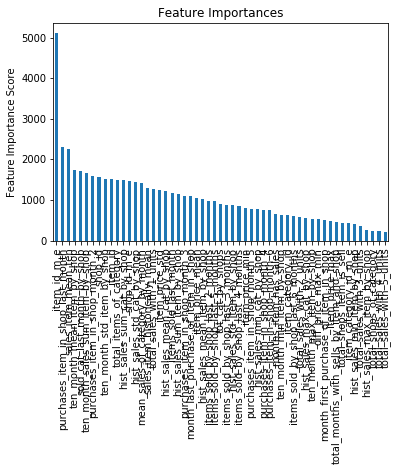

In [86]:
target_col = "label"

predictors = [x for x in F.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost = XGBRegressor(
 learning_rate=0.01,
 n_estimators=2000,
 max_depth=optimal_parameters["max_depth"],
 min_child_weight=optimal_parameters["min_child_weight"],
 gamma=optimal_parameters["gamma"],
 subsample=optimal_parameters["subsample"],
 colsample_bytree=optimal_parameters["colsample_by_tree"],
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fit_model(xgboost, F, predictors, target_col)

In [87]:
test_predictions = xgboost.predict(f[predictors])

In [88]:
root_mean_squared_error(f[target_col], test_predictions)

1.0927847070923598

In [89]:
jb.dump(xgboost, "models/16-xgb_mean_encodings_smoothed-30.pkl")

['models/16-xgb_mean_encodings_smoothed-30.pkl']

# RANDOM FOREST & MODELS THAT DOESN'T ACCEPT NA VALUES

### Analyze NA values

In [24]:
df.isna().sum()

shop_id                                         0
item_id                                         0
label                                           0
item_category_id                                0
hist_sales_sum_cat_by_shop                      0
hist_sales_mean_cat_by_shop                     0
hist_sales_std_cat_by_shop                    907
hist_sales_min_cat_by_shop                      0
hist_sales_max_cat_by_shop                      0
sold_cat_last_month_by_shop                     0
total_shops_of_category                         2
total_items_of_category                         2
mean_sales_of_category_by_month                 2
tot_cat_by_shops                                0
items_sold_last_month                           0
items_sold_by_shop_last_2_months                0
items_sold_by_shop_last_3_months                0
items_sold_by_shop_last_4_months                0
items_sold_by_shop_last_5_months                0
items_sold_by_shop_last_6_months                0


In [25]:
# For item_price features, take main of category
grouped = df.groupby("item_category_id").agg({"item_price_max":"mean", "item_price_mean":"mean", "item_price_min":"mean", "item_price_std":"mean", "diff_price_max_min":"mean"}).reset_index()
grouped.head()

,item_category_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min
0,2,3240.127737,2704.384533,1976.975036,276.215121,1263.152701
1,3,2879.226732,2277.276775,1576.107446,236.696546,1303.119286
2,4,399.000000,380.799624,98.000000,53.523906,301.000000
3,5,712.668966,620.084411,264.430069,70.666692,448.238897
4,6,3068.554455,2169.018964,1282.533208,346.132264,1786.021248


In [26]:
df["id"] = [x for x in range(len(df))]
df.head()

,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units,item_category_id_m_e,item_id_m_e,shop_id_m_e,id
0,2,31,1.0,37,985.0,29.848485,12.364569,12.0,55.0,41.0,57.0,1768.0,1.058596,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,699.0,581.503264,147.62,152.605715,551.38,53.0,42.875000,16.000000,32.0,905.0,100.0,45.0,18.0,12.0,1.475649,1.601418,1.632068,0
1,2,486,3.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,1.137269,59.0,791.0,928.0,789.0,790.0,709.0,704.0,1.833333,11.0,0.752773,3.0,1.0,1.625,13.0,0.744024,3.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,32.0,20.0,8.0,300.0,296.062587,108.90,25.821148,191.10,49.0,120.076923,119.272727,13.0,1053.0,152.0,38.0,15.0,6.0,2.017585,2.935829,1.632068,1
2,2,787,1.0,49,283.0,9.433333,6.673072,2.0,33.0,0.0,55.0,160.0,1.102808,59.0,791.0,928.0,789.0,790.0,709.0,704.0,1.000000,1.0,NaN,1.0,1.0,1.000,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,26.0,1.0,420.0,418.859223,227.00,13.747712,193.00,28.0,25.888889,25.888889,9.0,182.0,22.0,1.0,1.0,0.0,1.957160,2.180552,1.632068,2
3,2,794,1.0,73,167.0,5.218750,3.816216,1.0,16.0,2.0,55.0,36.0,1.137269,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3300.0,3282.352941,3000.00,72.760688,300.00,8.0,4.250000,4.250000,4.0,17.0,0.0,0.0,0.0,0.0,2.017585,1.731475,1.632068,3
4,2,968,1.0,40,2295.0,69.545455,24.951316,38.0,175.0,46.0,57.0,4917.0,1.107460,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,399.0,357.765780,55.00,90.061632,344.00,43.0,41.250000,9.454545,16.0,497.0,50.0,9.0,4.0,4.0,1.560805,1.383910,1.632068,4


In [27]:
df_item_price_na = df[df.item_price_max.isna()]
df_item_price_na.drop(columns=["item_price_max", "item_price_mean", "item_price_std", "item_price_min", "diff_price_max_min"], inplace=True)
print(len(df_item_price_na))

8400


/home/urielkelman/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
df_item_price_na = pd.merge(df_item_price_na, grouped, on="item_category_id", how="inner")
print(len(df_item_price_na))

df_item_price_na = df_item_price_na[df.columns]
print(len(df_item_price_na))
df_item_price_na.columns == df.columns

8400
8400


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [29]:
print(len(df))
df = df_item_price_na.append(df).drop_duplicates(subset=["id"], keep="first").drop(columns=["id"])
print(len(df))
df.head()

126961
126961


,shop_id,item_id,label,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop,total_shops_of_category,total_items_of_category,mean_sales_of_category_by_month,tot_cat_by_shops,items_sold_last_month,items_sold_by_shop_last_2_months,items_sold_by_shop_last_3_months,items_sold_by_shop_last_4_months,items_sold_by_shop_last_5_months,items_sold_by_shop_last_6_months,ten_month_mean_item_by_shop,ten_month_sales_sum_item_by_shop,ten_month_std_item_by_shop,ten_month_max_item_by_shop,ten_month_min_item_by_shop,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell,sales_item_historically_mean,sales_item_mean_ten,months_item_has_sales,total_sales_with_1_units,total_sales_with_2_units,total_sales_with_3_units,total_sales_with_4_units,total_sales_with_5_units,item_category_id_m_e,item_id_m_e,shop_id_m_e
0,2,1578,4.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,1.279538,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.516634,3.328920,1.632068
1,2,1583,9.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,1.279538,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.516634,5.223192,1.632068
2,2,1586,1.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,1.279538,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.516634,2.586696,1.632068
3,2,3034,1.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,1.279538,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.516634,1.658943,1.632068
4,2,3756,2.0,20,1959.0,85.173913,38.111859,17.0,198.0,116.0,52.0,141.0,1.279538,59.0,791.0,928.0,789.0,790.0,709.0,704.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,3305.410013,2895.204685,1847.347984,384.031814,1458.062029,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.516634,2.334184,1.632068


In [30]:
df["hist_sales_std_cat_by_shop"] = df["hist_sales_std_cat_by_shop"].fillna(0)
df["hist_sales_std_item_by_shop"] = df["hist_sales_std_item_by_shop"].fillna(0)
df["month_last_purchase_of_item_in_shop"] = df["month_last_purchase_of_item_in_shop"].fillna(-1)
df["month_first_purchase_of_item_in_shop"] = df["month_first_purchase_of_item_in_shop"].fillna(-1)
df["item_price_std"] = df["item_price_std"].fillna(0)
df["total_shops_item_is_sell"] = df["total_shops_item_is_sell"].fillna(0)
df["total_shops_of_category"] = df["total_shops_of_category"].fillna(0)
df["total_items_of_category"] = df["total_items_of_category"].fillna(0)

df["mean_sales_of_category_by_month"] = df["mean_sales_of_category_by_month"].fillna(0)
df["ten_month_mean_item_by_shop"] = df["ten_month_mean_item_by_shop"].fillna(0)
df["ten_month_sales_sum_item_by_shop"] = df["ten_month_sales_sum_item_by_shop"].fillna(0)
df["ten_month_std_item_by_shop"] = df["ten_month_std_item_by_shop"].fillna(0)
df["ten_month_max_item_by_shop"] = df["ten_month_max_item_by_shop"].fillna(0)
df["ten_month_min_item_by_shop"] = df["ten_month_min_item_by_shop"].fillna(0)
df["sales_item_historically_mean"] = df["sales_item_historically_mean"].fillna(0)
df["sales_item_mean_ten"] = df["sales_item_mean_ten"].fillna(0)

In [31]:
df.isna().sum()

shop_id                                     0
item_id                                     0
label                                       0
item_category_id                            0
hist_sales_sum_cat_by_shop                  0
hist_sales_mean_cat_by_shop                 0
hist_sales_std_cat_by_shop                  0
hist_sales_min_cat_by_shop                  0
hist_sales_max_cat_by_shop                  0
sold_cat_last_month_by_shop                 0
total_shops_of_category                     0
total_items_of_category                     0
mean_sales_of_category_by_month             0
tot_cat_by_shops                            0
items_sold_last_month                       0
items_sold_by_shop_last_2_months            0
items_sold_by_shop_last_3_months            0
items_sold_by_shop_last_4_months            0
items_sold_by_shop_last_5_months            0
items_sold_by_shop_last_6_months            0
ten_month_mean_item_by_shop                 0
ten_month_sales_sum_item_by_shop  

### Split, train and save model

## RANDOM FOREST

In [38]:
features = df

target_col = "label"
predictors = [x for x in features.columns if x != target_col]

jb.dump(predictors, "model_parameters/predictors_rf.pkl")

predictors

['shop_id',
 'item_id',
 'item_category_id',
 'hist_sales_sum_cat_by_shop',
 'hist_sales_mean_cat_by_shop',
 'hist_sales_std_cat_by_shop',
 'hist_sales_min_cat_by_shop',
 'hist_sales_max_cat_by_shop',
 'sold_cat_last_month_by_shop',
 'total_shops_of_category',
 'total_items_of_category',
 'mean_sales_of_category_by_month',
 'tot_cat_by_shops',
 'items_sold_last_month',
 'items_sold_by_shop_last_2_months',
 'items_sold_by_shop_last_3_months',
 'items_sold_by_shop_last_4_months',
 'items_sold_by_shop_last_5_months',
 'items_sold_by_shop_last_6_months',
 'ten_month_mean_item_by_shop',
 'ten_month_sales_sum_item_by_shop',
 'ten_month_std_item_by_shop',
 'ten_month_max_item_by_shop',
 'ten_month_min_item_by_shop',
 'hist_sales_mean_item_by_shop',
 'hist_sales_sum_item_by_shop',
 'hist_sales_std_item_by_shop',
 'hist_sales_max_item_by_shop',
 'hist_sales_min_item_by_shop',
 'purchases_item_in_shop_last_month',
 'purchases_item_in_shop_month_2',
 'purchases_item_in_shop_month_3',
 'purchases_

In [39]:
X = features[predictors]
y = features[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [40]:
'''random_grid = {'bootstrap': [True, False],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}'''

"random_grid = {'bootstrap': [True, False],\n 'min_samples_leaf': [1, 2, 4],\n 'min_samples_split': [2, 5, 10]}"

In [43]:
regressor = RandomForestRegressor(n_jobs=4, random_state=27, criterion="mse", n_estimators=2000, max_features='auto', max_depth=8, min_samples_split=2, min_samples_leaf=4)

In [44]:
# clf = RandomizedSearchCV(regressor, random_grid, random_state=27, scoring='neg_mean_squared_error', n_jobs=4, verbose=3)

In [45]:
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=4,
                      oob_score=False, random_state=27, verbose=0,
                      warm_start=False)

In [46]:
# rfRegressor = clf.best_estimator_ 

In [47]:
predictions = regressor.predict(X_test)

root_mean_squared_error(y_test, predictions)

1.1750117876362498

In [49]:
jb.dump(regressor, "models/18-rf_with_encodings.pkl")

['models/18-rf_with_encodings.pkl']

## XGBOOST without nans

In [34]:
features = df

optimal_parameters = jb.load("model_parameters/xgb_parameters.pkl")
optimal_parameters

F, f = train_test_split(features, test_size = 0.1, random_state=42)
print("Train size:", len(F))
print("Test size:", len(f))

Train size: 114264
Test size: 12697


Predictors are: ['shop_id', 'item_id', 'item_category_id', 'hist_sales_sum_cat_by_shop', 'hist_sales_mean_cat_by_shop', 'hist_sales_std_cat_by_shop', 'hist_sales_min_cat_by_shop', 'hist_sales_max_cat_by_shop', 'sold_cat_last_month_by_shop', 'total_shops_of_category', 'total_items_of_category', 'mean_sales_of_category_by_month', 'tot_cat_by_shops', 'items_sold_last_month', 'items_sold_by_shop_last_2_months', 'items_sold_by_shop_last_3_months', 'items_sold_by_shop_last_4_months', 'items_sold_by_shop_last_5_months', 'items_sold_by_shop_last_6_months', 'ten_month_mean_item_by_shop', 'ten_month_sales_sum_item_by_shop', 'ten_month_std_item_by_shop', 'ten_month_max_item_by_shop', 'ten_month_min_item_by_shop', 'hist_sales_mean_item_by_shop', 'hist_sales_sum_item_by_shop', 'hist_sales_std_item_by_shop', 'hist_sales_max_item_by_shop', 'hist_sales_min_item_by_shop', 'purchases_item_in_shop_last_month', 'purchases_item_in_shop_month_2', 'purchases_item_in_shop_month_3', 'purchases_item_in_shop_mon

/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/urielkelman/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Model Report
RMSE : 0.9797795046068741


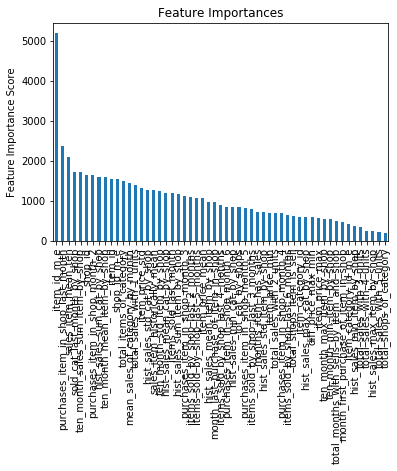

In [36]:
target_col = "label"

predictors = [x for x in F.columns if x not in target_col]

print("Predictors are:", predictors)

xgboost = XGBRegressor(
 learning_rate=0.01,
 n_estimators=2000,
 max_depth=optimal_parameters["max_depth"],
 min_child_weight=optimal_parameters["min_child_weight"],
 gamma=optimal_parameters["gamma"],
 subsample=optimal_parameters["subsample"],
 colsample_bytree=optimal_parameters["colsample_by_tree"],
 objective='reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fit_model(xgboost, F, predictors, target_col)

In [37]:
test_predictions = xgboost.predict(f[predictors])

print(root_mean_squared_error(f[target_col], test_predictions))

jb.dump(xgboost, "models/17-xgb_with_non_nans.pkl")

1.0595381113190494


['models/17-xgb_with_non_nans.pkl']